In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
import utils
import seaborn as sns

In [4]:
df = pd.read_csv("./input/DataSet/Train.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [102]:
test_df = pd.read_csv("./input/DataSet/Test.csv")

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Description

* Total 2395 Cols
* Col 1 is ID
* Col 2 is Target Variable
* Col 3 - Col 2397 Features

Train.csv - 17521 X 2395

Test.csv - 20442 X 2394

Interstingly test.csv has more number of rows, clearly it is generalisation problem, The more our model overfits the Train data it will fail epicly in test. So we need to Identify how similar our test and train data are.

### For starters lets analyse Train data and see how our target variable is distributed




In [13]:
col2 = df.groupby('Col2')['Col2']

In [16]:
# Percentage distribution target col
col2.count() / len(df) * 100

Col2
0    89.949204
1    10.050796
Name: Col2, dtype: float64

* It is evident that The dataset is highly skewed

Col2
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Col2, dtype: object

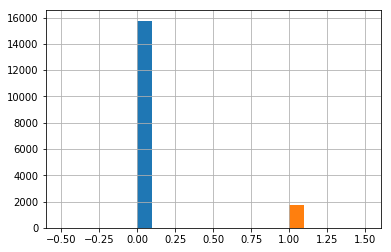

In [12]:
col2.hist()

### Lets Analyse the data type distribution and look for categorical columns if any

In [23]:
cols = utils.select_dtypes(df, [np.int, np.float])

In [41]:
# lets get columns other than int and float
non_numeric_df = df[df.columns.difference(cols)]

In [44]:
non_numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 3 columns):
Col1      17521 non-null object
Col747    626 non-null object
Col836    624 non-null object
dtypes: object(3)
memory usage: 410.8+ KB


In [43]:
print(non_numeric_df['Col747'].unique())
print(non_numeric_df['Col836'].unique())


[nan '-' '0' '1' 0.0 5.0 '3']
[nan '-' '0' 0.0 '5']


In [48]:
print(non_numeric_df[non_numeric_df['Col747'] == '-']['Col747'].count())
print(non_numeric_df[non_numeric_df['Col836'] == '-']['Col836'].count())

133
144


## The Columns `Col747` and `Col836` are treated as object and it has string literal `-` 

* Col747 - 133 (`-` found)
* Col836 - 144 (`-` found)

**Lets go ahead and replace it with 0.0**

Lets use `pandas dataframe replace function` [refer documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.replace.html)


In [51]:
df.replace({'Col747': '-', 'Col836': '-'}, 0.0, inplace=True)


In [52]:
# lets verify the same
print(df[df['Col747'] == '-']['Col747'].count())
print(df[df['Col836'] == '-']['Col836'].count())

0
0


In [53]:
# Lets type cast above columns to float
cols_treated_as_object= ['Col747', 'Col836']
df[cols_treated_as_object] = df[cols_treated_as_object].astype('float64')

In [75]:
# Lets save the intermediate df
df.to_csv("./input/Train_dt_v1.csv", index=False, header=True)

In [76]:
import gc
del non_numeric_df
gc.collect()

82995

### lets Check the zero variance columns

In [100]:
zero_var_cols = df.nunique()[lambda x: x==1].index
len(zero_var_cols)

2

In [101]:
zero_var_cols

Index(['Col724', 'Col813'], dtype='object')

In [104]:
# lets verify it against test data
test_df[zero_var_cols].nunique()

Col724    1
Col813    2
dtype: int64

### Lets Go ahead and analyse null Columns

In [56]:
null_columns = utils.get_null_columns(df)

In [61]:
len(null_columns) #Get Total Number of null columns

759

In [59]:
null_columns_df = df[null_columns]
null_columns_df.head()

,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,...,Col930,Col931,Col932,Col933,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,9.293496,8.570479,10.063117,10.271758,0.548538,0.403366,NaN,NaN,1.486524,1.728324,...,NaN,0.000000,0.000000,0.000000,214.0,214.0,68.0,22.0,22.0,7.0
1,12.462385,12.280493,12.167132,12.136876,1.167898,2.676398,NaN,NaN,0.792123,0.934556,...,1.0,0.306122,0.306122,0.326087,41.0,41.0,38.0,12.0,12.0,11.0
2,16.496090,16.749305,16.532874,16.128357,1.145182,2.203874,NaN,NaN,0.422264,0.498347,...,NaN,0.740458,0.740458,0.794749,378.0,378.0,310.0,21.0,21.0,16.0
3,13.419061,13.624018,13.541837,13.429097,1.204010,0.536304,NaN,NaN,0.437243,0.521341,...,NaN,0.502662,0.502662,0.465228,702.0,702.0,644.0,951.0,951.0,743.0
4,NaN,14.764533,14.551021,NaN,NaN,NaN,NaN,NaN,NaN,1.344637,...,4.0,0.532091,0.532091,0.442589,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


In [215]:
null_percentage = df.isna().sum() / len(df)

In [93]:
percent_50 = null_percentage[null_percentage > 0.50]
percent_50_cols = list(percent_50.index)
len(percent_50_cols)

222

In [68]:
percent_90 = null_percentage[null_percentage > 0.90]

In [86]:
percent_90_cols = list(percent_90.index)

In [128]:
percent_90_df = df[percent_90_cols+['Col2']]
len(percent_90_cols)

52

**There are 52 Columns which has more than 90 percent null values**

Lets see what we can do with it

In [105]:
test_null = test_df.isna().sum() / len(test_df)


In [109]:
test_90 = test_null[test_null > 0.90]

In [83]:
percent_99 = null_percentage[null_percentage > 0.99]

In [85]:
percent_99_cols = list(percent_99.index)

In [141]:
percent_99_df = df[percent_99_cols+ ['Col2']]
percent_99_df.describe()

,Col171,Col266,Col288,Col463,Col485,Col724,Col813,Col2
count,110.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0,17521.000000
mean,3.572727,1.714286,1.571429,1.714286,1.571429,0.0,0.0,0.100508
std,2.589531,0.487950,0.534522,0.487950,0.534522,0.0,0.0,0.300685
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000
25%,1.000000,1.500000,1.000000,1.500000,1.000000,0.0,0.0,0.000000
50%,3.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,0.000000
75%,5.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,0.000000
max,9.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0,1.000000


In [90]:
skew = percent_99_df.skew()
skew

Col171    0.703045
Col266   -1.229634
Col288   -0.374166
Col463   -1.229634
Col485   -0.374166
Col724    0.000000
Col813    0.000000
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4ca7ea470>,
      dtype=object)

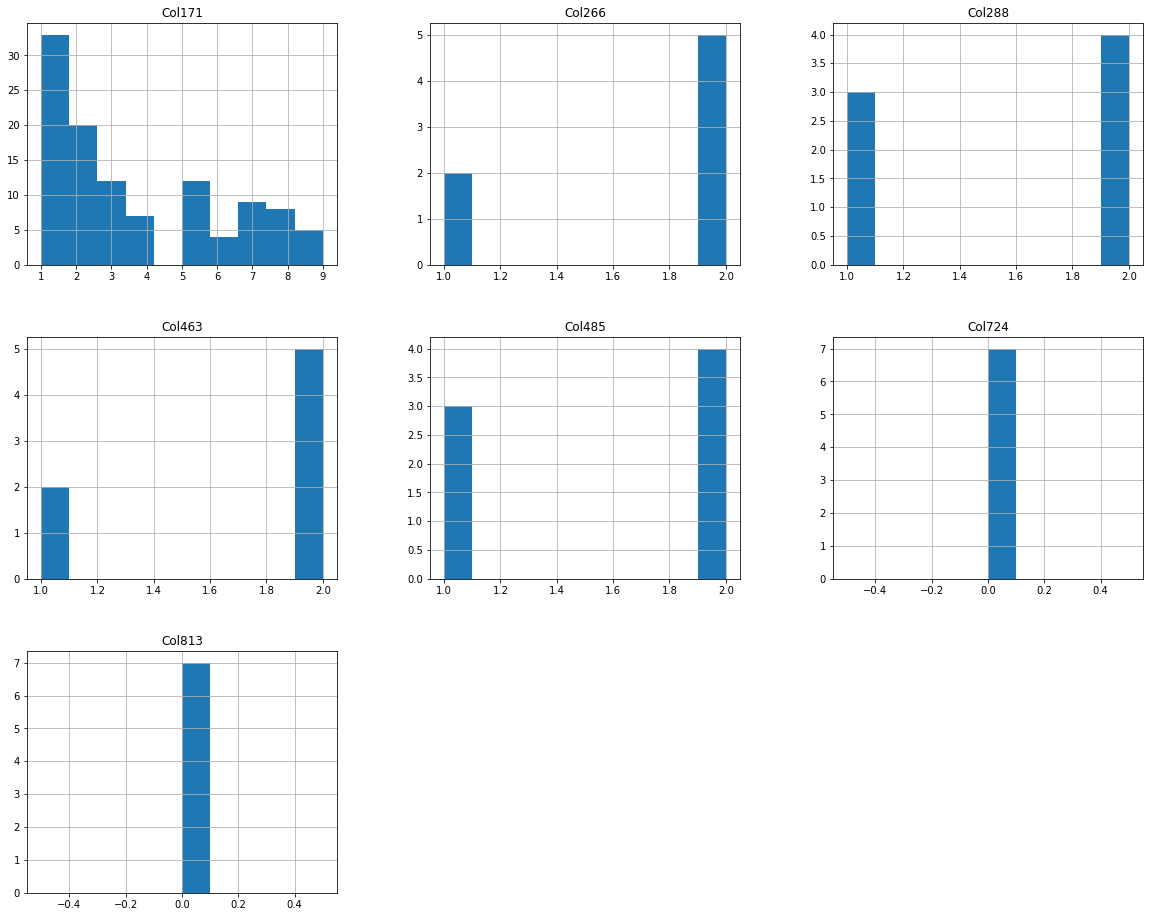

In [135]:
percent_99_df.hist(figsize=(20,16))

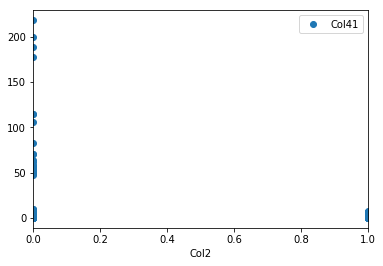

In [156]:
percent_90_df[[percent_90_cols[3], 'Col2']].plot(x='Col2', y=percent_90_cols[3], style='o')

In [129]:
corr = percent_90_df.corr()

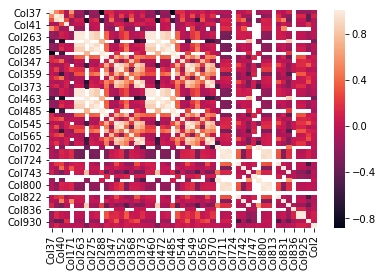

In [130]:
sns.heatmap(corr)

## Lets Analyse the 90% Null values against target column

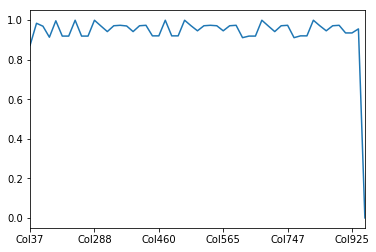

In [151]:
percent_90_1_df = percent_90_df[percent_90_df['Col2'] == 1]
temp = percent_90_1_df.isna().sum() / len(percent_90_1_df)
temp.plot()

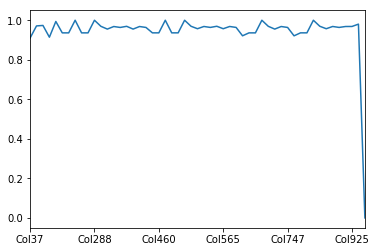

In [157]:
percent_90_0_df = percent_90_df[percent_90_df['Col2'] == 0]
temp2 = percent_90_0_df.isna().sum() / len(percent_90_0_df)
temp2.plot()

In [144]:
percent_99_df.groupby('Col2').count()

,Col171,Col266,Col288,Col463,Col485,Col724,Col813
Col2,,,,,,,
0,103,5,5,5,5,5,5
1,7,2,2,2,2,2,2


In [158]:
transforms = []

In [159]:
drop_tranform = {
    'action': 'DROP',
    'columns': percent_90_cols,
}

In [160]:
df.drop(columns=percent_90_cols, axis=1, inplace=True)

In [162]:
df.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGHGSN,1,1.086711e+04,8.648345e+03,1.576618e+04,2.890466e+04,5.273655e+03,2.346153e+04,1.285597e+04,2.871509e+04,...,0,1,0,1,214.0,214.0,68.0,22.0,22.0,7.0
1,RIMHI5ZGP,0,2.584312e+05,2.179633e+05,1.866287e+05,1.866287e+05,2.154519e+05,1.923615e+05,1.726538e+05,1.666974e+05,...,0,0,0,0,41.0,41.0,38.0,12.0,12.0,11.0
2,RIHOG1SZU,0,1.459355e+07,1.260060e+07,1.100315e+07,1.010315e+07,1.879882e+07,1.514035e+07,5.320778e+06,6.906324e+06,...,0,1,1,0,378.0,378.0,310.0,21.0,21.0,16.0
3,RIHOLMQWU,0,6.727043e+05,8.181116e+05,6.794893e+05,6.794893e+05,8.257254e+05,7.605803e+05,3.577134e+05,4.236612e+05,...,0,0,0,0,702.0,702.0,644.0,951.0,951.0,743.0
4,RIHO584ET,0,-1.218742e+06,-3.005361e+06,-1.666241e+05,-2.403574e+06,2.583183e+06,2.086546e+06,5.938358e+06,5.446532e+06,...,0,0,0,0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


# Let Analyse less the 50% null values


In [216]:
percent_l_50 = null_percentage[null_percentage <= 0.50]

In [217]:
percent_l_50 = percent_l_50[percent_l_50 > 0.0]

percent_l_50_cols = list(percent_l_50.index)

In [218]:
len(percent_l_50)

0

In [210]:


def impute_col_test(df, cols):
    impute_transform = []
    for column in cols:
        imputer = {}
        imputer['col'] =column
        skew = df[column].skew()
        if skew <= 0.5 and skew >= -0.5:
            mean = df[column].mean()
            imputer['value']=mean
            df[column].fillna(mean, inplace=True)
        else:
            median = df[column].median()
            df[column].fillna(median,inplace=True)
            imputer['value']=mean
        impute_transform.append(imputer)
    
    return df,impute_transform

In [211]:
df, impute_value = impute_col_test(df, percent_l_50_cols)

In [214]:
impute_transform = {
    'action': 'impute',
    'columns': impute_value
}

In [219]:
# Lets save the intermediate df
df.to_csv("./input/Train_dt_v2.csv", index=False, header=True)

In [238]:
null_percentage = df.isna().sum() / len(df)

In [240]:
rem_col = null_percentage[null_percentage > 0]

In [242]:
remaining_cols = list(rem_col.index)

In [248]:
remaining_cols_df = df[remaining_cols]


In [252]:
drop_transform_2 = {
    'action': 'impute',
    'columns': remaining_cols
}

In [233]:
len(rem_cols)

2343

In [254]:
def drop_col(df,columns):
    df.drop(columns=columns, axis=1, inplace=True)
    return df

In [255]:
df = drop_col(df,remaining_cols)

In [256]:
# Lets save the intermediate df
df.to_csv("./input/Train_dt_v3.csv", index=False, header=True)

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Columns: 2173 entries, Col1 to Col2397
dtypes: float64(624), int64(1548), object(1)
memory usage: 290.5+ MB


In [260]:
null_percentage = df.isna().sum() / len(df)
ng = null_percentage[null_percentage > 0]
len(ng)

0

In [264]:
transforms =[]

In [265]:
transforms.append(drop_tranform)
transforms.append(drop_transform_2)
transforms.append(impute_transform)



In [266]:
import json

In [276]:
with open('transforms.json', 'w') as f:
    f.write(json.dumps({"transforms": transforms}))

## Cleaning Test Data

In [280]:
test_df = drop_col(test_df, drop_tranform['columns'])

In [282]:
test_df = drop_col(test_df, drop_transform_2['columns'])

In [283]:
def impute(df, columns):
    for column in columns:
        df[column['col']].fillna(column['value'], inplace=True)
    
    return df

In [284]:
test_df = impute(test_df, impute_transform['columns'])

In [286]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20442 entries, 0 to 20441
Columns: 2172 entries, Col1 to Col2397
dtypes: float64(626), int64(1545), object(1)
memory usage: 338.7+ MB


In [287]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Columns: 2173 entries, Col1 to Col2397
dtypes: float64(624), int64(1548), object(1)
memory usage: 290.5+ MB


In [285]:
test_df.to_csv("./input/Test_Cleaned.csv", index=False, header=True)